# TimeGAN Tutorial

## Time-series Generative Adversarial Networks

- Paper: Jinsung Yoon, Daniel Jarrett, Mihaela van der Schaar, "Time-series Generative Adversarial Networks," Neural Information Processing Systems (NeurIPS), 2019.

- Paper link: https://papers.nips.cc/paper/8789-time-series-generative-adversarial-networks

- Last updated Date: April 24th 2020

- Code author: Jinsung Yoon (jsyoon0823@gmail.com)

This notebook describes the user-guide of a time-series synthetic data generation application using timeGAN framework. We use Stock, Energy, and Sine dataset as examples.

### Prerequisite
Clone https://github.com/jsyoon0823/timeGAN.git to the current directory.

## Necessary packages and functions call

- timegan: Synthetic time-series data generation module
- data_loading: 2 real datasets and 1 synthetic datasets loading and preprocessing
- metrics: 
    - discriminative_metrics: classify real data from synthetic data
    - predictive_metrics: train on synthetic, test on real
    - visualization: PCA and tSNE analyses

In [1]:
## Necessary packages
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings("ignore")

# 1. TimeGAN model
from timegan import timegan
# 2. Data loading
from data_loading import real_data_loading, sine_data_generation
# 3. Metrics
from metrics.discriminative_metrics import discriminative_score_metrics
from metrics.predictive_metrics import predictive_score_metrics
from metrics.visualization_metrics import visualization

In [2]:
data = pd.read_csv('/home/daniel/sin.csv')

<AxesSubplot:>

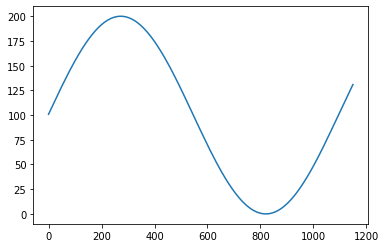

In [3]:
data.sin[:1150].plot(kind = 'line')

## Data Loading

Load original dataset and preprocess the loaded data.

- data_name: stock, energy, or sine
- seq_len: sequence length of the time-series data

In [4]:
def inverse_TimeGAN_preprocessing(data, idx, denom, minimum, reorder = True):
    ori_scale_data = data * denom + minimum
    ori_data = [None]*len(ori_scale_data)
    
    if reorder:
        for index, ori_index in enumerate(idx):
            ori_data[ori_index] = ori_scale_data[index]
    else:
        ori_data = ori_scale_data
    
    real_data = []
    for i in range(len(ori_data) - 1):
        real_data.append(ori_data[i][0])
    
    for el in ori_data[-1]:
        real_data.append(el)
    
    return real_data
        

In [5]:
ori_data, idx, denom, minimum = real_data_loading('/home/daniel/sin.csv', 1)

In [6]:
len(ori_data)

22725

In [7]:
get_back_data = inverse_TimeGAN_preprocessing(ori_data, idx, denom, minimum)

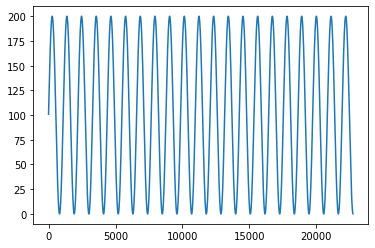

In [8]:
plt.plot(np.asarray(get_back_data)[:, 1])

## Set network parameters

TimeGAN network parameters should be optimized for different datasets.

- module: gru, lstm, or lstmLN
- hidden_dim: hidden dimensions
- num_layer: number of layers
- iteration: number of training iterations
- batch_size: the number of samples in each batch

In [9]:
## Newtork parameters
parameters = dict()

parameters['module'] = 'gru' 
parameters['hidden_dim'] = 24
parameters['num_layer'] = 3
parameters['iterations'] = 2000
parameters['batch_size'] = 128

In [10]:
np.asarray(ori_data).shape

(22725, 1, 2)

## Run TimeGAN for synthetic time-series data generation

TimeGAN uses the original data and network parameters to return the generated synthetic data.

In [11]:
# Run TimeGAN
generated_data = timegan(ori_data, parameters)   
print('Finish Synthetic Data Generation')

Start Embedding Network Training
step: 0/2000, e_loss: 0.3236
step: 1000/2000, e_loss: 0.0312
Finish Embedding Network Training
Start Training with Supervised Loss Only
step: 0/2000, s_loss: 0.0
step: 1000/2000, s_loss: 0.0
Finish Training with Supervised Loss Only
Start Joint Training
step: 0/2000, d_loss: 2.0768, g_loss_u: 0.697, g_loss_s: 0.0, g_loss_v: 0.7589, e_loss_t0: 0.0411
step: 1000/2000, d_loss: 1.7653, g_loss_u: 1.1588, g_loss_s: 0.0, g_loss_v: 0.0413, e_loss_t0: 0.0055
Finish Joint Training
Finish Synthetic Data Generation


## Evaluate the generated data

### 1. Discriminative score

To evaluate the classification accuracy between original and synthetic data using post-hoc RNN network. The output is |classification accuracy - 0.5|.

- metric_iteration: the number of iterations for metric computation.

In [12]:
metric_iteration = 5

discriminative_score = list()
for _ in range(metric_iteration):
    temp_disc = discriminative_score_metrics(ori_data, generated_data)
    discriminative_score.append(temp_disc)

print('Discriminative score: ' + str(np.round(np.mean(discriminative_score), 4)))

Instructions for updating:
Please use tf.global_variables instead.
Discriminative score: 0.1967


## Evaluate the generated data

### 2. Predictive score

To evaluate the prediction performance on train on synthetic, test on real setting. More specifically, we use Post-hoc RNN architecture to predict one-step ahead and report the performance in terms of MAE.

In [13]:
predictive_score = list()
for tt in range(metric_iteration):
    temp_pred = predictive_score_metrics(ori_data, generated_data)
    predictive_score.append(temp_pred)   
    
print('Predictive score: ' + str(np.round(np.mean(predictive_score), 4)))

UnimplementedError: TensorArray has size zero, but element shape [?,1] is not fully defined. Currently only static shapes are supported when packing zero-size TensorArrays.
	 [[Node: predictor/rnn/TensorArrayStack/TensorArrayGatherV3 = TensorArrayGatherV3[_class=["loc:@predictor/rnn/TensorArray"], dtype=DT_FLOAT, element_shape=[?,1], _device="/job:localhost/replica:0/task:0/device:CPU:0"](predictor/rnn/TensorArray, predictor/rnn/TensorArrayStack/range, predictor/rnn/while/Exit_1)]]

Caused by op 'predictor/rnn/TensorArrayStack/TensorArrayGatherV3', defined at:
  File "/usr/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/daniel/time-series/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/daniel/time-series/lib/python3.6/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/home/daniel/time-series/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 619, in start
    self.io_loop.start()
  File "/home/daniel/time-series/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 199, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.6/asyncio/base_events.py", line 438, in run_forever
    self._run_once()
  File "/usr/lib/python3.6/asyncio/base_events.py", line 1451, in _run_once
    handle._run()
  File "/usr/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/home/daniel/time-series/lib/python3.6/site-packages/tornado/ioloop.py", line 688, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/daniel/time-series/lib/python3.6/site-packages/tornado/ioloop.py", line 741, in _run_callback
    ret = callback()
  File "/home/daniel/time-series/lib/python3.6/site-packages/tornado/gen.py", line 814, in inner
    self.ctx_run(self.run)
  File "/home/daniel/time-series/lib/python3.6/site-packages/contextvars/__init__.py", line 38, in run
    return callable(*args, **kwargs)
  File "/home/daniel/time-series/lib/python3.6/site-packages/tornado/gen.py", line 775, in run
    yielded = self.gen.send(value)
  File "/home/daniel/time-series/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 374, in dispatch_queue
    yield self.process_one()
  File "/home/daniel/time-series/lib/python3.6/site-packages/tornado/gen.py", line 250, in wrapper
    runner = Runner(ctx_run, result, future, yielded)
  File "/home/daniel/time-series/lib/python3.6/site-packages/tornado/gen.py", line 741, in __init__
    self.ctx_run(self.run)
  File "/home/daniel/time-series/lib/python3.6/site-packages/contextvars/__init__.py", line 38, in run
    return callable(*args, **kwargs)
  File "/home/daniel/time-series/lib/python3.6/site-packages/tornado/gen.py", line 775, in run
    yielded = self.gen.send(value)
  File "/home/daniel/time-series/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 358, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/daniel/time-series/lib/python3.6/site-packages/tornado/gen.py", line 234, in wrapper
    yielded = ctx_run(next, result)
  File "/home/daniel/time-series/lib/python3.6/site-packages/contextvars/__init__.py", line 38, in run
    return callable(*args, **kwargs)
  File "/home/daniel/time-series/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/daniel/time-series/lib/python3.6/site-packages/tornado/gen.py", line 234, in wrapper
    yielded = ctx_run(next, result)
  File "/home/daniel/time-series/lib/python3.6/site-packages/contextvars/__init__.py", line 38, in run
    return callable(*args, **kwargs)
  File "/home/daniel/time-series/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 538, in execute_request
    user_expressions, allow_stdin,
  File "/home/daniel/time-series/lib/python3.6/site-packages/tornado/gen.py", line 234, in wrapper
    yielded = ctx_run(next, result)
  File "/home/daniel/time-series/lib/python3.6/site-packages/contextvars/__init__.py", line 38, in run
    return callable(*args, **kwargs)
  File "/home/daniel/time-series/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 302, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/daniel/time-series/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 539, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/daniel/time-series/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2867, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/daniel/time-series/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2895, in _run_cell
    return runner(coro)
  File "/home/daniel/time-series/lib/python3.6/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/home/daniel/time-series/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3072, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/daniel/time-series/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3263, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/home/daniel/time-series/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-ba84752cc006>", line 3, in <module>
    temp_pred = predictive_score_metrics(ori_data, generated_data)
  File "/home/daniel/TimeGAN/metrics/predictive_metrics.py", line 79, in predictive_score_metrics
    y_pred, p_vars = predictor(X, T)
  File "/home/daniel/TimeGAN/metrics/predictive_metrics.py", line 72, in predictor
    p_outputs, p_last_states = tf.nn.dynamic_rnn(p_cell, x, dtype=tf.float32, sequence_length = t)
  File "/home/daniel/time-series/lib/python3.6/site-packages/tensorflow/python/ops/rnn.py", line 614, in dynamic_rnn
    dtype=dtype)
  File "/home/daniel/time-series/lib/python3.6/site-packages/tensorflow/python/ops/rnn.py", line 780, in _dynamic_rnn_loop
    final_outputs = tuple(ta.stack() for ta in output_final_ta)
  File "/home/daniel/time-series/lib/python3.6/site-packages/tensorflow/python/ops/rnn.py", line 780, in <genexpr>
    final_outputs = tuple(ta.stack() for ta in output_final_ta)
  File "/home/daniel/time-series/lib/python3.6/site-packages/tensorflow/python/ops/tensor_array_ops.py", line 335, in stack
    return self.gather(math_ops.range(0, self.size()), name=name)
  File "/home/daniel/time-series/lib/python3.6/site-packages/tensorflow/python/ops/tensor_array_ops.py", line 361, in gather
    element_shape=element_shape)
  File "/home/daniel/time-series/lib/python3.6/site-packages/tensorflow/python/ops/gen_data_flow_ops.py", line 4158, in _tensor_array_gather_v3
    flow_in=flow_in, dtype=dtype, element_shape=element_shape, name=name)
  File "/home/daniel/time-series/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/daniel/time-series/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2956, in create_op
    op_def=op_def)
  File "/home/daniel/time-series/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

UnimplementedError (see above for traceback): TensorArray has size zero, but element shape [?,1] is not fully defined. Currently only static shapes are supported when packing zero-size TensorArrays.
	 [[Node: predictor/rnn/TensorArrayStack/TensorArrayGatherV3 = TensorArrayGatherV3[_class=["loc:@predictor/rnn/TensorArray"], dtype=DT_FLOAT, element_shape=[?,1], _device="/job:localhost/replica:0/task:0/device:CPU:0"](predictor/rnn/TensorArray, predictor/rnn/TensorArrayStack/range, predictor/rnn/while/Exit_1)]]


## Evaluate the generated data

### 3. Visualization

We visualize the original and synthetic data distributions using PCA and tSNE analysis.

In [14]:
visualization(ori_data, generated_data, 'pca')
visualization(ori_data, generated_data, 'tsne')

ValueError: n_components=2 must be between 0 and min(n_samples, n_features)=1 with svd_solver='full'

In [15]:
get_back_data_synth = inverse_TimeGAN_preprocessing(generated_data, idx, denom, minimum, reorder = True)

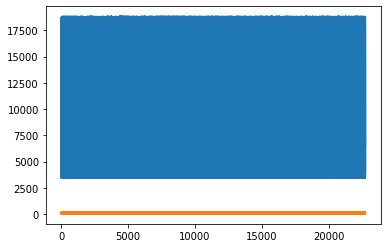

In [17]:
plt.plot(np.asarray(get_back_data_synth))

In [ ]:
some_gen = np.concatenate((generated_data[0,:,1], generated_data[1,:,1], generated_data[2,:,1], generated_data[3,:,1], generated_data[4,:,1], generated_data[5,:,1]), axis = 0)

In [ ]:
some_gen

In [ ]:
plt.plot(some_gen)

In [ ]:
ori_data = np.asarray(ori_data)
some_ori = np.concatenate((ori_data[0,:,1], ori_data[1,:,1], ori_data[2,:,1], ori_data[3,:,1], ori_data[4,:,1], ori_data[5,:,1]), axis = 0)

In [ ]:
plt.plot(some_ori)